In [1]:
from datetime import datetime
import math
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import mplfinance as mpf
import numpy as np
import os 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf 

In [2]:
if not mt5.initialize(login = XXXXXXX, server = 'Ava-Real 1-MT5', password = 'XXXXXXX'):
    print('MetaTrader5 account expired.')
else:
    candles = pd.DataFrame(mt5.copy_rates_from_pos('EURUSD', mt5.TIMEFRAME_H1, 0, 50000))
    mt5.shutdown()
    
candles.head() 
                      

,time,open,high,low,close,tick_volume,spread,real_volume
0,1439784000,1.10970,1.10983,1.10920,1.10949,2760,7,3664500000
1,1439787600,1.10949,1.10977,1.10865,1.10890,2429,7,2895602000
2,1439791200,1.10890,1.10904,1.10816,1.10894,2719,7,3592961000
3,1439794800,1.10895,1.11012,1.10891,1.10959,3184,7,4046990000
4,1439798400,1.10958,1.11120,1.10928,1.10971,5563,7,7848995000


In [3]:
candles['date'] = pd.to_datetime(candles['time'], unit= 's').dt.tz_localize('Etc/UTC')
candles.rename(columns={'tick_volume' : 'volume'}, inplace = True)
candles.set_index('date', inplace = True)

del candles['time']
del candles['real_volume']
candles.head()

,open,high,low,close,volume,spread
date,,,,,,
2015-08-17 04:00:00+00:00,1.10970,1.10983,1.10920,1.10949,2760,7
2015-08-17 05:00:00+00:00,1.10949,1.10977,1.10865,1.10890,2429,7
2015-08-17 06:00:00+00:00,1.10890,1.10904,1.10816,1.10894,2719,7
2015-08-17 07:00:00+00:00,1.10895,1.11012,1.10891,1.10959,3184,7
2015-08-17 08:00:00+00:00,1.10958,1.11120,1.10928,1.10971,5563,7


In [4]:
print(candles.iloc[0].name, '-', candles.iloc[-1].name)

2015-08-17 04:00:00+00:00 - 2023-08-14 20:00:00+00:00


In [5]:
candles.describe()

,open,high,low,close,volume,spread
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.125939,1.126692,1.125210,1.125945,3211.984920,8.314180
std,0.054546,0.054479,0.054603,0.054545,2880.543486,4.618798
min,0.953890,0.955910,0.953560,0.953880,48.000000,1.000000
25%,1.091070,1.091840,1.090390,1.091067,1240.750000,7.000000
50%,1.123400,1.124100,1.122760,1.123420,2307.000000,9.000000
75%,1.169573,1.170390,1.168823,1.169565,4248.000000,9.000000
max,1.254890,1.255540,1.254330,1.254900,47168.000000,180.000000


In [6]:
candles[candles['spread'] > 18]

,open,high,low,close,volume,spread
date,,,,,,
2015-08-23 00:00:00+00:00,1.13753,1.13937,1.13684,1.13751,7349,50
2015-08-30 00:00:00+00:00,1.11743,1.12139,1.11695,1.12098,5756,50
2015-09-06 00:00:00+00:00,1.11609,1.11623,1.11413,1.11530,2967,50
2015-09-13 00:00:00+00:00,1.13301,1.13581,1.13262,1.13407,3598,50
2015-09-20 00:00:00+00:00,1.12822,1.12960,1.12810,1.12894,4617,50
...,...,...,...,...,...,...
2023-05-29 21:00:00+00:00,1.07068,1.07127,1.07065,1.07080,141,26
2023-06-26 21:00:00+00:00,1.09049,1.09077,1.09040,1.09057,266,20
2023-06-28 21:00:00+00:00,1.09115,1.09138,1.09055,1.09126,204,19


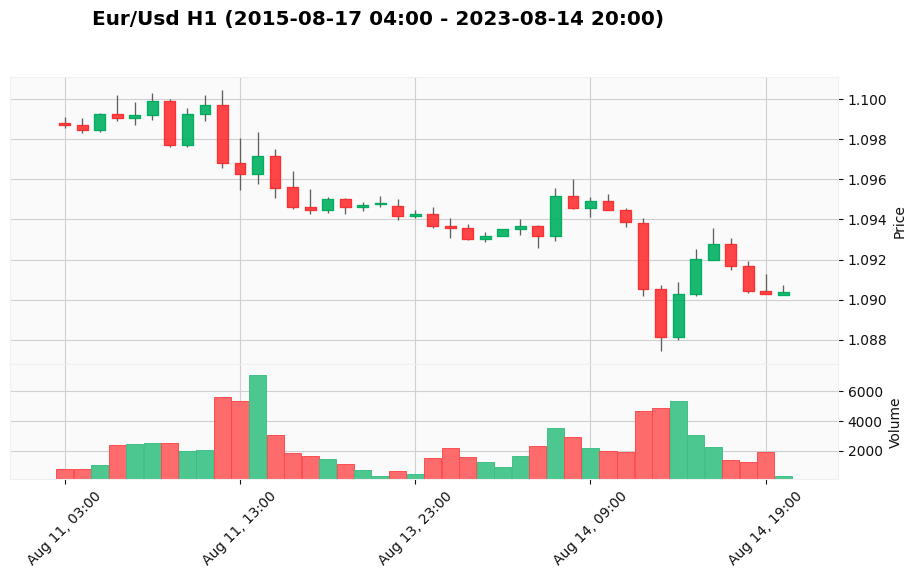

In [10]:
title = 'Eur/Usd H1 (' + str(candles.iloc[0].name)[:16] + ' - ' + str(candles.iloc[-1].name)[:16]+')'

mpf.plot(
    candles.iloc[-42:],
    type = 'candle',
    volume = True,
    figratio= (24,12),
    style= 'yahoo',
    title= title
)

## Analisi Tecnica

#### Media Mobile

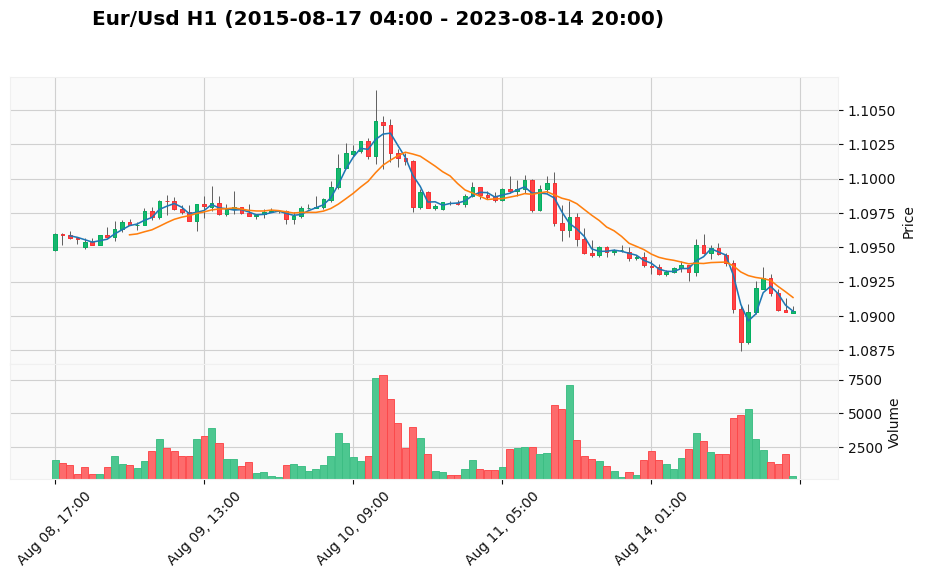

In [12]:
mpf.plot(
    candles.iloc[-100:],
    mav = (3,11),
    type = 'candle',
    volume = True,
    figratio = (24,12),
    style= 'yahoo',
    title = title
)

#### Bande di Bollinger

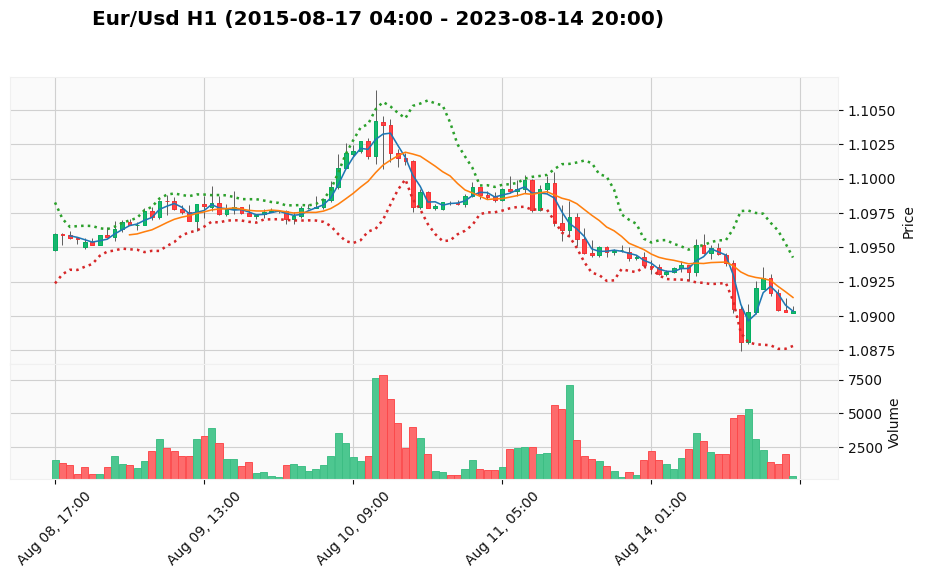

In [14]:
mean = candles['close']
mean = mean.rolling(window=10).mean()
std_dev = candles['close']
std_dev = std_dev.rolling(window=10).std()
candles['UpperBB'] = mean + (2 * std_dev)
candles['LowerBB'] = mean - (2 * std_dev)
bollinger_bands = candles[['UpperBB', 'LowerBB']]

bollinger_bands_plot = mpf.make_addplot(bollinger_bands[-100:], linestyle= 'dotted')
mpf.plot(
    candles.iloc[-100:],
    type= 'candle',
    mav = (3, 11),
    volume = True,
    figratio = (24,12),
    style = 'yahoo',
    addplot= bollinger_bands_plot,
    title = title
)

#### Prezzo su volume 

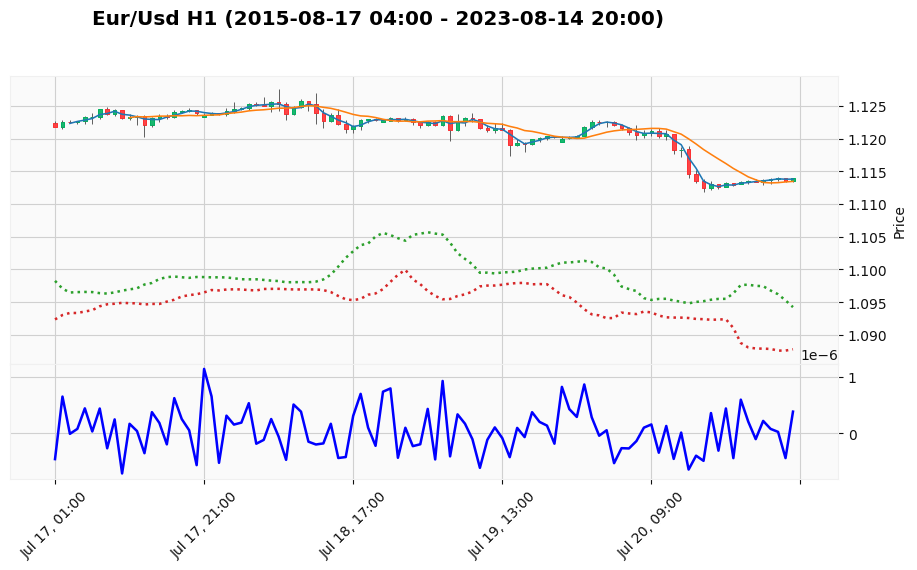

In [15]:
price_over_volume = (candles['close'] - candles['open']) / candles['volume']
candles['price_over_vol'] = price_over_volume

price_over_volume_plot = mpf.make_addplot(price_over_volume[-500 : -400], panel = 1, color = 'blue')
mpf.plot(
    candles.iloc[-500 : -400],
    type = 'candle',
    mav = (3,11),
    figratio = (24,12),
    style = 'yahoo',
    addplot = [bollinger_bands_plot, price_over_volume_plot],
    title=title
)


#### Accelerazione volumetrica

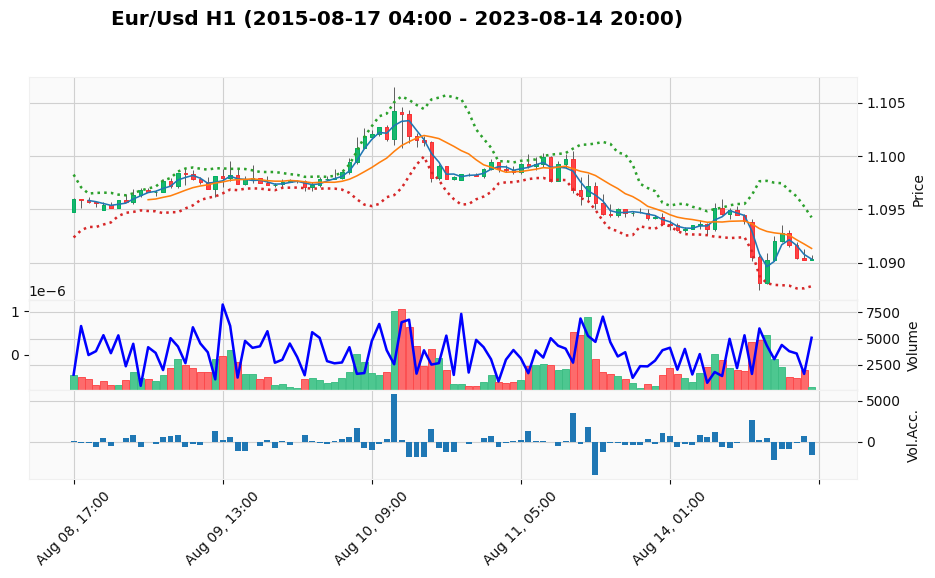

In [16]:
volume_diff = candles['volume'] - candles['volume'].shift(1)
volume_diff_plot = mpf.make_addplot(volume_diff[-100:], panel=2, type='bar', ylabel='Vol.Acc.')
candles['vol_diff'] = volume_diff

mpf.plot(
    candles.iloc[-100:],  
    type='candle', 
    volume=True, 
    mav=(3, 11),
    figratio=(24,12), 
    style='yahoo', 
    addplot=[
        bollinger_bands_plot, 
        price_over_volume_plot, 
        volume_diff_plot
    ], 
    title=title
)

# Creazione dataset temporale

## Normalizzazione dei dati

In [17]:
scaler = MinMaxScaler(feature_range=(0.2, 0.8))
candles_norm = scaler.fit_transform(candles)

print(candles.iloc[0])
print('  ------')
print(candles_norm[0])

open              1.109700e+00
high              1.109830e+00
low               1.109200e+00
close             1.109490e+00
volume            2.760000e+03
spread            7.000000e+00
UpperBB                    NaN
LowerBB                    NaN
price_over_vol   -7.608696e-08
vol_diff                   NaN
Name: 2015-08-17 04:00:00+00:00, dtype: float64
  ------
[0.51058472 0.50822014 0.51048309 0.51016544 0.23453311 0.22011173
        nan        nan 0.52083452        nan]


### Rimozione valori NaN

In [18]:
candles_norm = candles_norm[10:]

#### Costruzione dataset basato su serie temporali

In [19]:
x_candles = []
x_time = []
y =[]

step_back = 24

for i in range(len(candles_norm) - step_back):
    x_candles.append(candles_norm[i:i + step_back])
    t = candles.iloc[10 + i + step_back-1].name
    x_time.append([t.hour / 24, t.weekday() / 7])
    y.append(candles_norm[i+step_back][3])

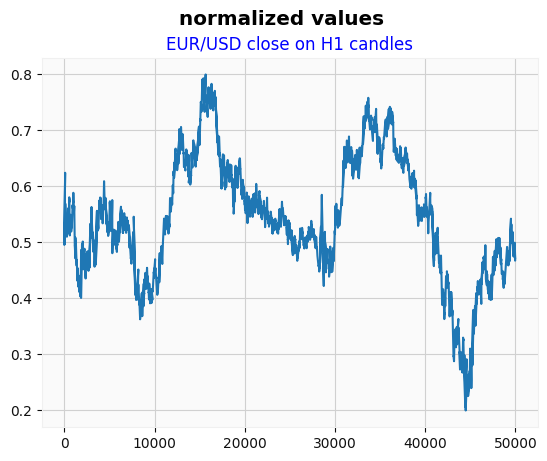

In [20]:
plt.plot(y)
plt.title('EUR/USD close on H1 candles', fontdict={
    'fontsize': 12,
    'fontweight': 1,
    'color': 'blue',
    'verticalalignment': 'baseline',
    'horizontalalignment': 'center'
})
plt.suptitle('normalized values')
plt.show()

#### Creazione dataset per addestramento e validazione del modello predittivo

In [21]:
split_point = int(len(x_candles) * 0.9)

x_train_candles = np.asarray(x_candles[:split_point], dtype=np.float32)
x_train_time = np.asarray(x_time[:split_point], dtype=np.float32)
y_train = np.asarray(y[:split_point], dtype=np.float32)

x_test_candles = np.asarray(x_candles[split_point:], dtype=np.float32)
x_test_time = np.asarray(x_time[split_point:], dtype=np.float32)
y_test = np.asarray(y[split_point:], dtype=np.float32)

In [22]:
print(x_train_candles.shape)
print(x_train_time.shape)
print(y_train.shape)

print(x_test_candles.shape)
print(x_test_time.shape)
print(y_test.shape)

(44969, 24, 10)
(44969, 2)
(44969,)
(4997, 24, 10)
(4997, 2)
(4997,)


#### Scrittura architettura ibrida e compilazione del modello 

In [23]:
def get_conv_lstm_block(input, kernel_size_1, kernel_size_2):
    conv_1 = keras.layers.Conv1D(
        filters=24,
        kernel_size=kernel_size_1,
        activation=keras.activations.swish,
        padding='same'
    )(input)
    average_1 = keras.layers.AveragePooling1D()(conv_1)
    
    conv_2 = keras.layers.Conv1D(
        filters=48,
        kernel_size=kernel_size_2,
        activation=keras.activations.swish,
        padding='same'
    )(average_1)
    average_2 = keras.layers.AveragePooling1D()(conv_2)
    
    lstm_1 = keras.layers.LSTM(units=16, return_sequences=True)(average_2)
    lstm_2 = keras.layers.LSTM(units=16)(lstm_1)
    
    return lstm_2


input_candles = keras.Input(shape=(x_train_candles.shape[1:]), name='Candles')
input_time = keras.Input(shape=(x_train_time.shape[1]), name='Time')

conv_1 = get_conv_lstm_block(input_candles, kernel_size_1=3, kernel_size_2=2)
conv_2 = get_conv_lstm_block(input_candles, kernel_size_1=5, kernel_size_2=3)
conv_3 = get_conv_lstm_block(input_candles, kernel_size_1=11, kernel_size_2=7)

dense_time_1 = keras.layers.Dense(units=8, activation='swish')(input_time)
dense_time_2 = keras.layers.Dense(units=16, activation='swish')(dense_time_1)

conc = keras.layers.Concatenate(axis=-1)([conv_1, conv_2, conv_3, dense_time_2])

dense_1 = keras.layers.Dense(units=32, activation=keras.activations.swish)(conc)
dense_2 = keras.layers.Dense(units=32, activation=keras.activations.swish)(dense_1)

output = keras.layers.Dense(units=1, activation=keras.activations.linear)(dense_2)

model = keras.Model(inputs=[input_candles, input_time], outputs=output)

model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_absolute_error)

model.summary()

keras.utils.plot_model(model, "conv_lstm_net.png", show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Candles (InputLayer)        [(None, 24, 10)]             0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 24, 24)               744       ['Candles[0][0]']             
                                                                                                  
 conv1d_2 (Conv1D)           (None, 24, 24)               1224      ['Candles[0][0]']             
                                                                                                  
 conv1d_4 (Conv1D)           (None, 24, 24)               2664      ['Candles[0][0]']             
                                                                                              

In [24]:
history = model.fit(
    [x_train_candles, x_train_time],
    y_train,
    epochs=20,
    batch_size=2048,
    validation_data=(
        [x_test_candles, x_test_time],
        y_test
    )
)

Epoch 1/20
22/22 [==============================] - 18s 306ms/step - loss: 0.2138 - val_loss: 0.0606
Epoch 2/20
22/22 [==============================] - 4s 204ms/step - loss: 0.0830 - val_loss: 0.0598
Epoch 3/20
22/22 [==============================] - 5s 234ms/step - loss: 0.0459 - val_loss: 0.0179
Epoch 4/20
22/22 [==============================] - 5s 231ms/step - loss: 0.0116 - val_loss: 0.0124
Epoch 5/20
22/22 [==============================] - 5s 223ms/step - loss: 0.0086 - val_loss: 0.0069
Epoch 6/20
22/22 [==============================] - 5s 224ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 7/20
22/22 [==============================] - 5s 224ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 8/20
22/22 [==============================] - 5s 222ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 9/20
22/22 [==============================] - 5s 232ms/step - loss: 0.0066 - val_loss: 0.0072
Epoch 10/20
22/22 [==============================] - 5s 243ms/step - loss: 0.0064 - val_loss: 0.007

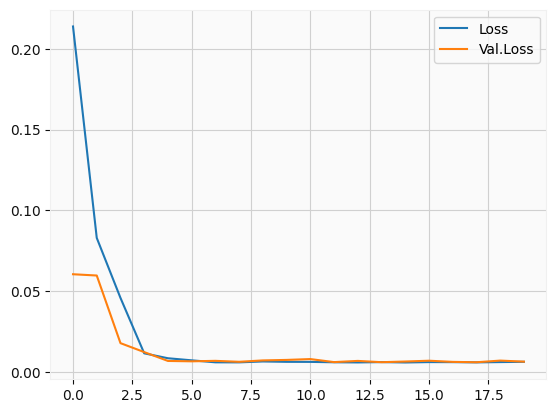

In [25]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

#### Utilizzo e validazione del modello predittivo

In [26]:
preds = model.predict([x_test_candles, x_test_time], batch_size=512)

10/10 [==============================] - 2s 19ms/step


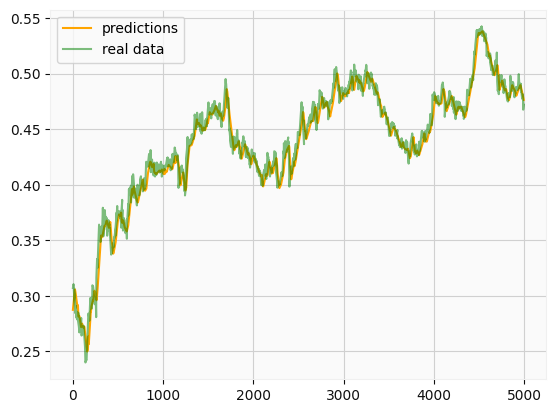

In [27]:
plt.plot(preds, color='orange', label='predictions')
plt.plot(y_test, color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [28]:
def denorm(value):
    example = [0.5 for x in range(10)]
    example[3] = value
    return scaler.inverse_transform([example])[0][3]

In [29]:
pips_total = 0
total_pips_history = []
single_pips_history = []

for i in range(split_point, len(x_candles)):
    prediction = preds[i - split_point][0]
    predicted_close = denorm(prediction)
    previous_close = denorm(candles_norm[i-1][3])
    actual_close = denorm(candles_norm[i][3])
    real_next_close = denorm(candles_norm[i+1][3])

    if previous_close < predicted_close:  # buy
        profit = real_next_close - actual_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)
        
    if previous_close > predicted_close:  # sell
        profit = actual_close - real_next_close
        pips_total += profit
        total_pips_history.append(pips_total)
        single_pips_history.append(profit)

Total earned 1.2579999999999978


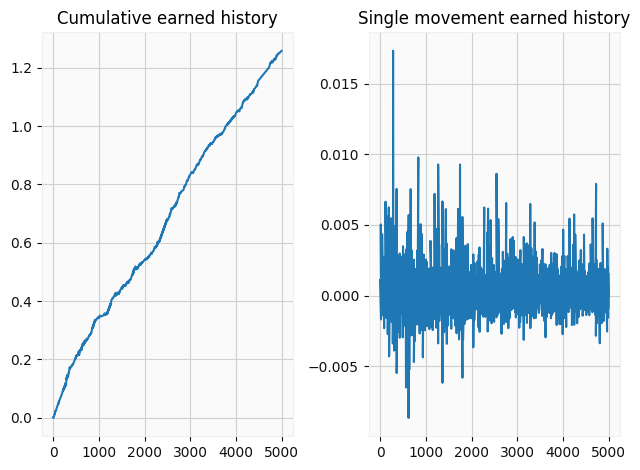

In [30]:
print('Total earned', pips_total)

plt.subplot(1, 2, 1)
plt.plot(total_pips_history)
plt.title('Cumulative earned history')

plt.subplot(1, 2, 2)
plt.plot(single_pips_history)
plt.title('Single movement earned history')

plt.tight_layout()
plt.show()